In [1]:
using DrWatson
@quickactivate

In [2]:
using main
using BlockDiagonals, LinearAlgebra, Plots, ProgressMeter
using Distributions, MCMCChains, Random

gr()
default(fmt=:png, levels=7)
ProgressMeter.ijulia_behavior(:clear);

In [3]:
function generate_model(; m = 5.0 ,s = 0.5, d = 10)
    R = prod(
    # [BlockDiagonal([diagm(ones(j)), [0.0 -1.0; 1.0 0.0], diagm(ones(d - j - 2))]) for j in 0:d-2]
        [
        BlockDiagonal(
            [diagm(ones(2j)),
            [0.0 -1.0; 1.0 0.0],
            diagm(ones(d - 2j - 2))]
        ) for j in 0:round(Int, d / 2 - 1)
    ]
    )

    Σ₁ = [s^abs(i - j) for i in 1:d, j in 1:d]
    Σ₂ = R * Σ₁ * R'
    μ = [-m .* ones(d), m .* ones(d)]
    Σ = [Σ₁, Σ₂]

    ξ = MixtureModel(
        [MvNormal(x, y) for (x, y) in zip(μ, Σ)],
        [0.5, 0.5]
    )
    return Model(ξ=ξ)
end

generate_model (generic function with 1 method)

In [4]:
function acfplots(chains, names, lags=0:2:20; kwargs...)
    plt = plot(0, 0)
    for (x, n) in zip(chains, names)
        plt = plot(plt, mean(1 .* (autocor(x, lags=[lags...])[:, :]), dims=1)', label=n; kwargs...)
    end
    return plt
end

function scatterplots(xs, names; baseplt=plot(0,0,label=nothing), l=400, kwargs...)
    L = length(xs)
    ds = sample(1:size(xs[1], 2), 2, replace=false)
    plts = [scatter(baseplt, x[:, ds[1]], x[:, ds[2]], label=names[i]) for (x, i) in zip(xs, eachindex(xs))]
    plot(plts..., axes=false, ticks=false; kwargs...)
end

function traceplots(xs, names, args...; baseplt=plot(0,0,label=nothing), l=400, kwargs...)
    L = length(xs)
    ds = sample(1:size(xs[1], 2), 1, replace=false)
    plts = [plot(x[:, ds[1]], label=names[i]; args...) for (x, i) in zip(xs, eachindex(xs))]
    plot(plts...; kwargs...)
end

function mean_ess(chains)
    return [ess_rhat(chn)[:, 2] |> mean for chn in chains]
end

function w2_minibatch(xs, model; eps=0.1, iters=100, k=100, N=64)
    results = zeros(length(xs))
    for (i, x) in zip(eachindex(xs), xs)
        z = Matrix(rand(model.ξ, size(x, 1))')
        results[i] = W2_minibatch(x, z, eps=eps, iters=iters, k=k, N=N)
    end
    return results
end

w2_minibatch (generic function with 1 method)

# Example: $\mathbb R^{2}$

In [5]:
model = generate_model(d=2);

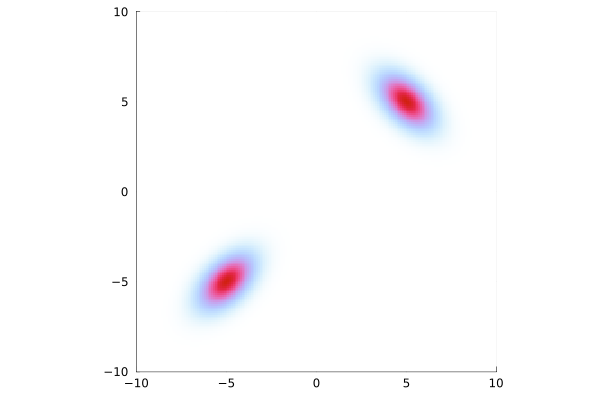

In [6]:
plot_params = Plot_params(
    plotband=10, quiveralpha=0, colorscheme=palette(:linear_wcmr_100_45_c42_n256, 100, rev=true)
);
plt() = plot_pdf(model, plot_params)
plt()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
  HMC:  0.9734569584583219


Acceptance Ratio = 0.9734
 40.999124 seconds (69.50 M allocations: 3.764 GiB, 4.61% gc time, 74.32% compilation time: 0% of which was recompilation)


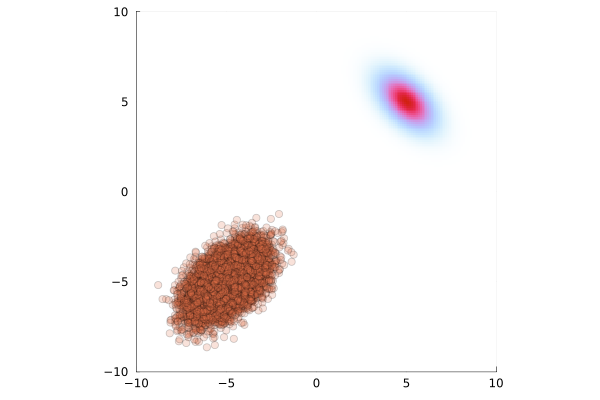

In [7]:
@time s1, a1 = mcmc(
    HMC(ϵ=0.5, L=40),
    model; n=1e4, n_burn=1e3
)
x_hmc = s1[a1, :]
chain_hmc = Chains(x_hmc)
scatter(plt(), x_hmc[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
  HaRAM:  0.9314607762930642


Acceptance Ratio = 0.9313
 11.161823 seconds (33.48 M allocations: 1.938 GiB, 6.80% gc time, 5.09% compilation time)


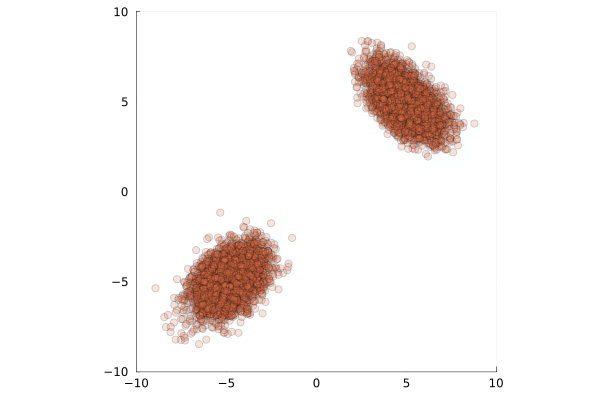

In [8]:
@time s2, a2 = mcmc(
    HaRAM(ϵ=0.55, L=20, γ=0.25),
    model; n=1e4, n_burn=1e3
)
x_haram = s2[a2, :]
chain_haram = Chains(x_haram)
scatter(plt(), x_haram[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM:  0.2737932915189528


Acceptance Ratio = 0.2749
  1.103301 seconds (3.01 M allocations: 190.499 MiB, 6.81% gc time, 62.75% compilation time: 1% of which was recompilation)


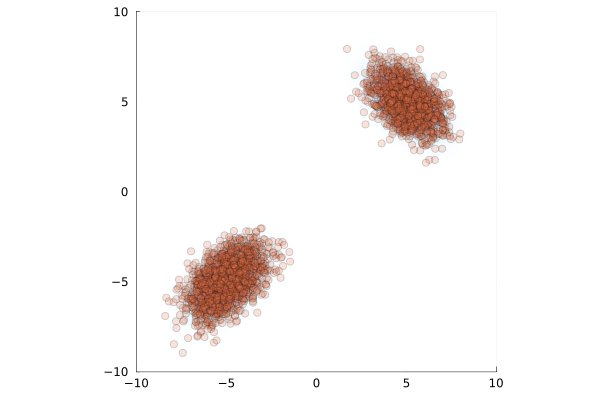

In [9]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 3), z=randn(model.d)),
    model; n=1e4, n_burn=1e3
)
x_ram = s3[a3, :]
chain_ram = Chains(x_ram)
scatter(plt(), x_ram[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:36
  PEHMC:  0.9564032697547684


Acceptance Ratio = 0.9591
 96.898596 seconds (198.07 M allocations: 8.928 GiB, 3.89% gc time, 41.96% compilation time)


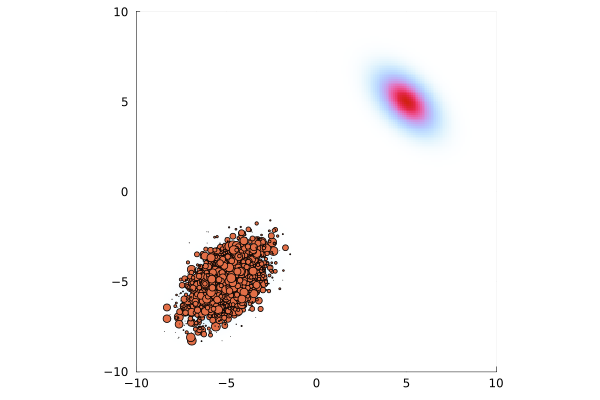

In [10]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.5, L=10, N=2),
    model; n=1e3, n_burn=1e2
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_pehmc = Chains(x_pehmc)
scatter(plt(), x_pehmc |> m2t, ms=w_pehmc * 5)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32
  HMC:  0.9718207435687665


Acceptance Ratio = 0.972
 33.018808 seconds (97.50 M allocations: 5.458 GiB, 6.46% gc time, 2.89% compilation time)


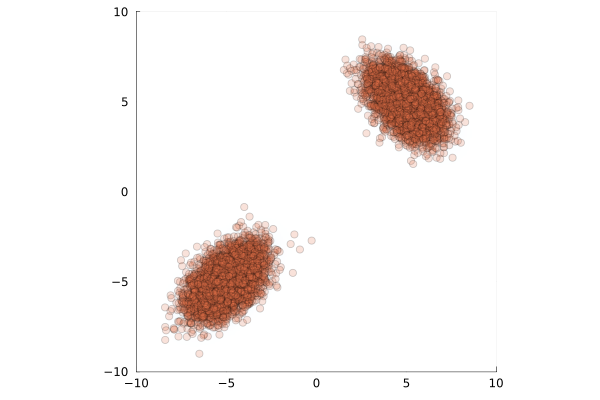

In [11]:
@time s5, a5 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HMC(ϵ=0.5, L=40),
    model; n=1e4, n_burn=1e3
)
x_pt_hmc = s5[a5, :]
chain_pt_hmc = Chains(x_pt_hmc)
scatter(plt(), x_pt_hmc[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32
  HMC:  0.970184528679211


Acceptance Ratio = 0.97
 32.070820 seconds (96.21 M allocations: 5.392 GiB, 6.54% gc time)


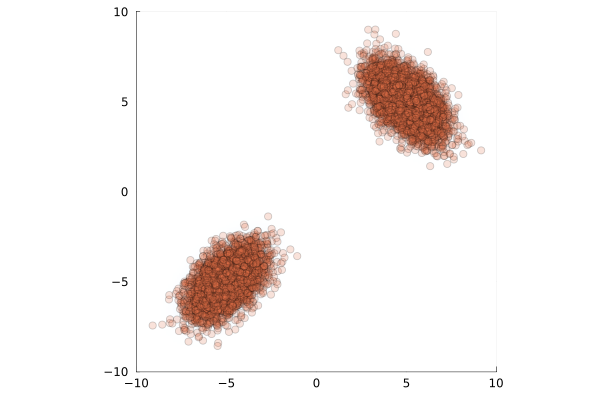

In [12]:
@time s6, a6 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HMC(ϵ=0.5, L=40),
    model; n=1e4, n_burn=1e3
)
x_pt_haram = s6[a6, :]
chain_pt_haram = Chains(x_pt_haram)
scatter(plt(), x_pt_haram[:, 1:2] |> m2t, ma=0.2)

In [13]:
names = ("HMC", "HaRAM", "RAM", "PE-HMC")
xs2d = [x_hmc, x_haram, x_ram, x_pehmc]
chains2d = [chain_hmc, chain_haram, chain_ram, chain_pehmc];

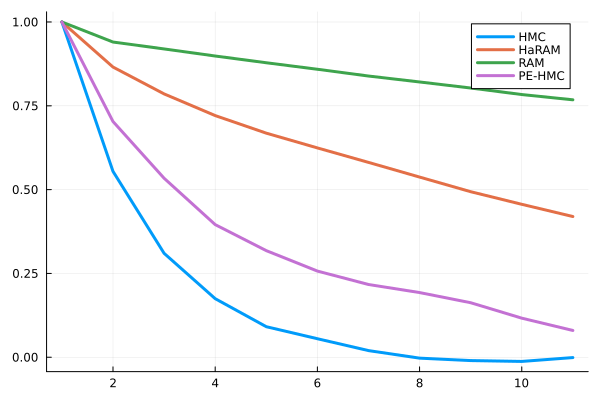

In [14]:
acfplots(chains2d, names, lw=3)

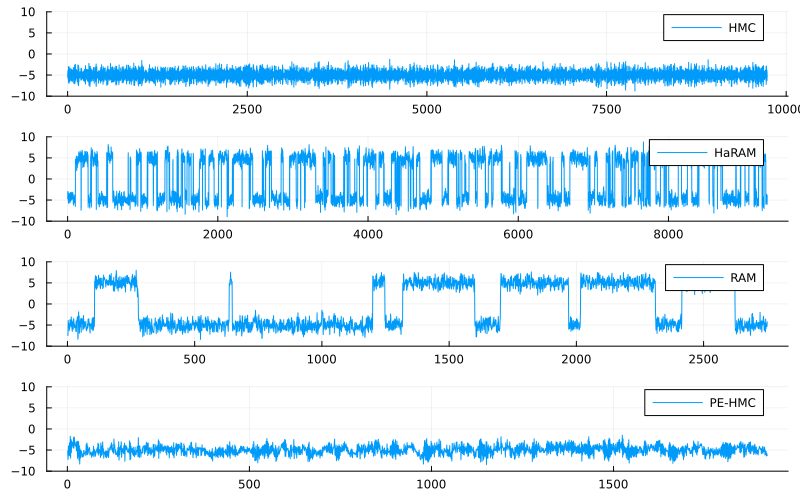

In [15]:
traceplots(xs2d, names, lw=1, layout=(4,1), ylim=(-10,10), l=100, size=(800, 500))

In [16]:
w2_minibatch(xs2d, model)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:13
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


4-element Vector{Float64}:
 0.11536493177717845
 0.0037918912779912467
 0.013587670280543026
 0.5867728534170776

# Example: $\mathbb R^{10}$

In [17]:
model = generate_model(d=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
  HMC:  0.7878374693209709


Acceptance Ratio = 0.7879
 13.167209 seconds (18.35 M allocations: 8.192 GiB, 6.72% gc time, 8.94% compilation time)


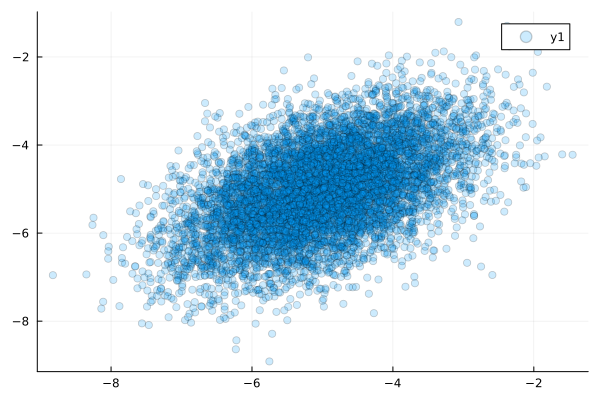

In [18]:
@time s1, a1 = mcmc(
    HMC(ϵ=0.65, L=20),
    model; n=1e4, n_burn=1e3
)
x_10_hmc = s1[a1, :]
chain_10_hmc = Chains(x_10_hmc)
scatter(x_10_hmc[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
  HaRAM:  0.6595764021452595


Acceptance Ratio = 0.6576
 29.107718 seconds (40.62 M allocations: 20.068 GiB, 7.54% gc time)


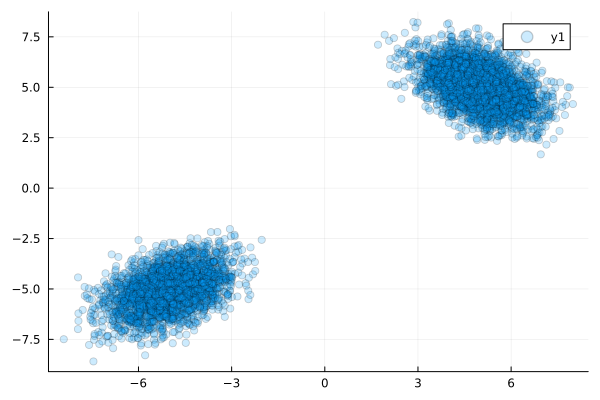

In [19]:
@time s2, a2 = mcmc(
    HaRAM(ϵ=0.55, L=25, γ=0.25),
    model; n=1e4, n_burn=1e3
)
x_10_haram = s2[a2, :]
chain_10_haram = Chains(x_10_haram)
scatter(x_10_haram[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM:  0.34278701936187617


Acceptance Ratio = 0.339
  0.611304 seconds (1.78 M allocations: 168.008 MiB, 18.53% compilation time)


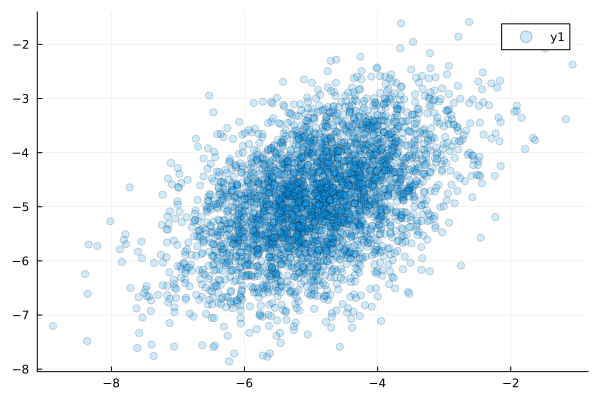

In [20]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 0.5), z=randn(model.d)),
    model; n=1e4, n_burn=1e3
)
x_10_ram = s3[a3, :]
chain_10_ram = Chains(x_10_ram)
scatter(x_10_ram[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:50
  PEHMC:  0.9164396003633061


Acceptance Ratio = 0.9212
110.849184 seconds (272.44 M allocations: 12.836 GiB, 3.30% gc time)


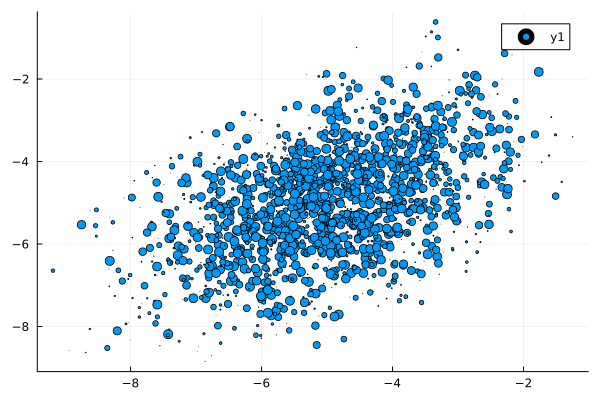

In [21]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.25, L=20, N=2),
    model; n=1e3, n_burn=1e2
)
x_10_pehmc, w_10_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
chain_10_pehmc = Chains(x_10_pehmc)
scatter(x_10_pehmc[:, 1:2] |> m2t, ms=w_10_pehmc * 5)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
  HMC:  0.7609308244705026


Acceptance Ratio = 0.7615
 36.437567 seconds (50.66 M allocations: 24.272 GiB, 7.58% gc time)


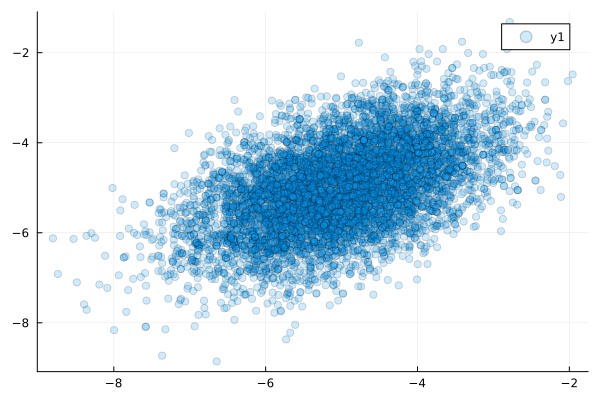

In [22]:
@time s5, a5 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HMC(ϵ=0.65, L=20),
    model; n=1e4, n_burn=1e3
)
x_10_pt_hmc = s5[a5, :]
chain_10_pt_hmc = Chains(x_10_pt_hmc)
scatter(x_10_pt_hmc[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:27
  HaRAM:  0.616580310880829


Acceptance Ratio = 0.6182
 87.959615 seconds (123.41 M allocations: 60.184 GiB, 7.36% gc time, 0.56% compilation time)


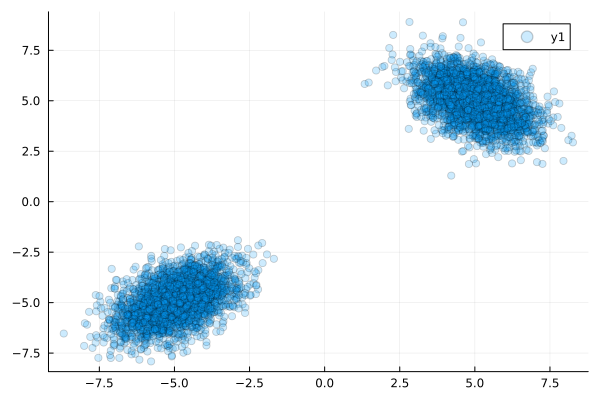

In [23]:
@time s6, a6 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HaRAM(ϵ=0.55, L=25, γ=0.25),
    model; n=1e4, n_burn=1e3
)
x_10_pt_haram = s6[a6, :]
chain_10_pt_haram = Chains(x_10_pt_haram)
scatter(x_10_pt_haram[:, 1:2] |> m2t, ma=0.2)

In [24]:
names = ("HMC", "HaRAM", "RAM", "PE-HMC")
names = ("HMC", "HaRAM", "RAM", "PE-HMC", "pt-hmc", "pt-haram")
xs10d = [x_10_hmc, x_10_haram, x_10_ram, x_10_pehmc, x_10_pt_hmc, x_10_pt_haram]
chains10d = [chain_10_hmc, chain_10_haram, chain_10_ram, chain_10_pehmc];

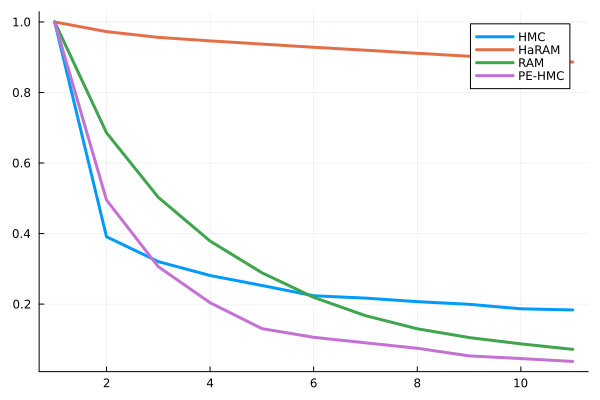

In [25]:
acfplots(chains10d, names, lw=3)

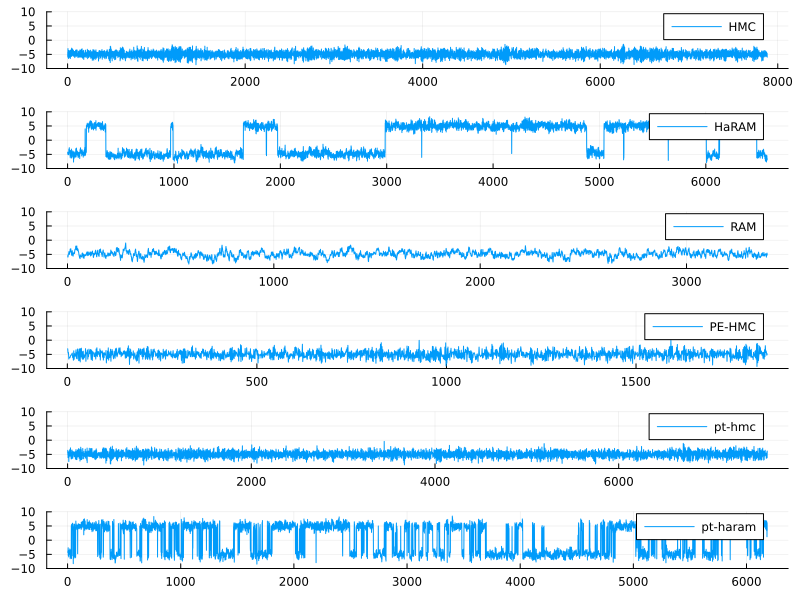

In [26]:
traceplots(xs10d, names, lw=1, layout=(6,1), ylim=(-10,10), l=100, size=(800, 600))

In [27]:
w2_minibatch(xs10d, model)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


6-element Vector{Float64}:
 0.37543132363750975
 0.07538089407849757
 0.9605946675688684
 1.588615915312902
 0.3720519848813706
 0.08107215922573116

# Example: $\mathbb R^{50}$

In [28]:
model = generate_model(d=50);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:39
  HMC:  0.7624125291569477


Acceptance Ratio = 0.7592
279.724579 seconds (20.50 M allocations: 469.355 GiB, 3.75% gc time, 0.46% compilation time)


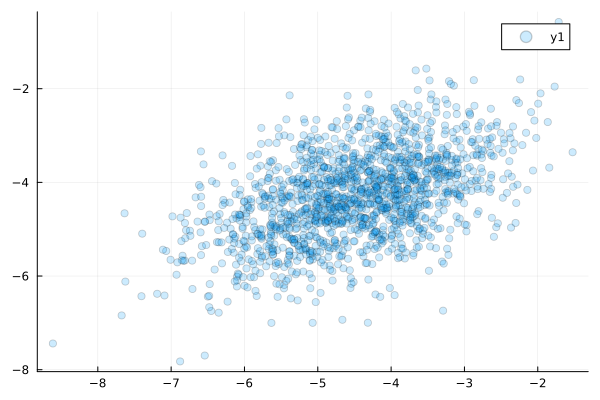

In [29]:
@time s1, a1 = mcmc(
    HMC(ϵ=0.5, L=40),
    model; n=2e3, n_burn=1e3
)
x_50_hmc = s1[a1, :]
chain_50_hmc = Chains(x_50_hmc)
scatter(x_50_hmc[:, 1:2] |> m2t, ma=0.2)

In [ ]:
@time s2, a2 = mcmc(
    DualAverage(λ=2, δ=0.7),
    HaRAM(),
    model; n=1_000, n_burn=1_000
)
x_50_haram = s2[a2, :]
chain_50_haram = Chains(x_50_haram)
scatter(x_50_haram[:, 1:2] |> m2t, ma=0.2)

Progress:  48%|███████████████████▊                     |  ETA: 0:06:55
  HaRAM:  Warming Up...

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM:  0.24958347217594135


Acceptance Ratio = 0.2308
  0.410925 seconds (510.12 k allocations: 99.725 MiB)


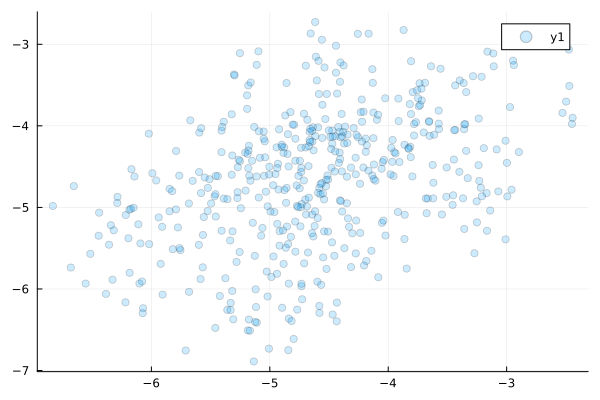

In [44]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(model.d, 0.25), z=randn(model.d)),
    model; n=2e3, n_burn=1e3
)
x_50_ram = s3[a3, :]
chain_50_ram = Chains(x_50_ram)
scatter(x_50_ram[:, 1:2] |> m2t, ma=0.2)

In [45]:
# @time s4, w4, a4 = mcmc(
#     PEHMC(ϵ=0.5, L=50, N=2),
#     model; n=1e3, n_burn=1e2
# )
# x_50_pehmc, w_50_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
# chain_50_pehmc = Chains(x_50_pehmc)
# scatter(x_50_pehmc |> m2t, ms=w_50_pehmc * 5)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:52
  HMC:  0.9582198001816531


Acceptance Ratio = 0.9621
232.294461 seconds (15.73 M allocations: 390.315 GiB, 3.43% gc time)


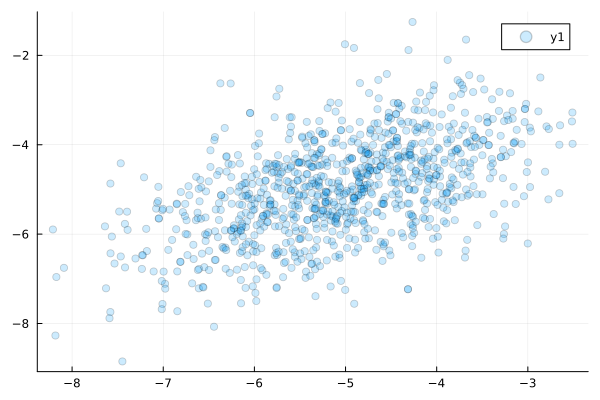

In [33]:
@time s5, a5 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HMC(ϵ=0.25, L=30),
    model; n=1e3, n_burn=1e2
)
x_50_pt_hmc = s5[a5, :]
chain_50_pt_hmc = Chains(x_50_pt_hmc)
scatter(x_50_pt_hmc[:, 1:2] |> m2t, ma=0.2)

Progress: 100%|█████████████████████████████████████████| Time: 0:07:41
  HaRAM:  0.659400544959128


Acceptance Ratio = 0.6647
461.982479 seconds (31.04 M allocations: 780.739 GiB, 3.21% gc time)


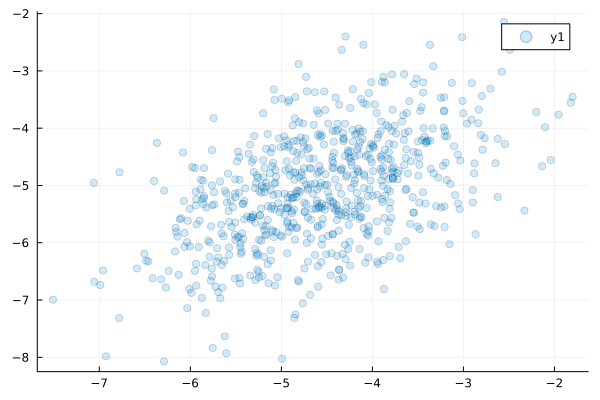

In [34]:
@time s6, a6 = mcmc(
    PT(τ=[1.0, 0.5, 0.1]),
    HaRAM(ϵ=0.25, L=30, γ=0.1),
    model; n=1e3, n_burn=1e2
)
x_50_pt_haram = s6[a6, :]
chain_50_pt_haram = Chains(x_50_pt_haram)
scatter(x_50_pt_haram[:, 1:2] |> m2t, ma=0.2)

In [46]:
names = ("HMC", "HaRAM", "RAM")
xs50d = [x_50_hmc, x_50_haram, x_50_ram]
chains50d = [chain_50_hmc, chain_50_haram, chain_50_ram];

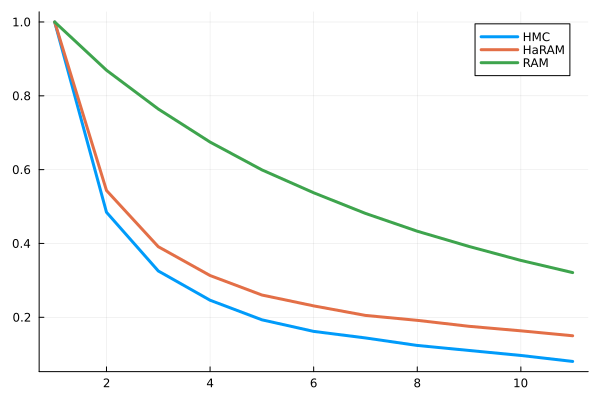

In [47]:
acfplots(chains50d, names, lw=3)

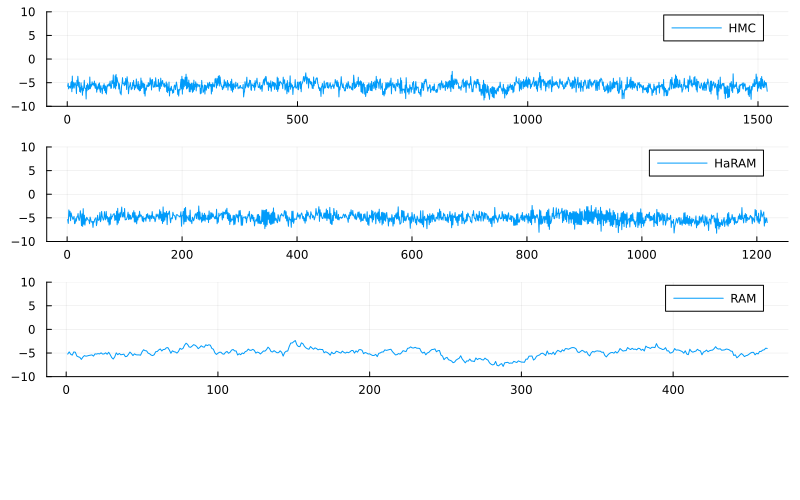

In [48]:
traceplots(xs50d, names, lw=1, layout=(4,1), ylim=(-10,10), l=100, size=(800, 500))

In [49]:
w2_minibatch(xs50d, model)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


3-element Vector{Float64}:
  9.809961537975862
 10.825242459002503
 34.67066204094702